# 4 
## 4.1 **准自然实验设计：干旱事件 + 双重差分（DiD）**

本研究以2010年干旱作为处理组识别事件，将县份分为“严重干旱组”（SPEI≤–1）与“轻微干旱组”（SPEI > –1）进行对比分析。采用固定效应面板回归模型

In [3]:
# 导入相关库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

In [4]:
import geopandas as gpd

In [18]:
df = pd.read_csv("data/guizhou_panel_cleaned.csv")

### 4.1.1 构造变量

In [19]:
# === 步骤 1：构造县份唯一ID ===
df['county_id'] = df['ENG_NAME'].astype('category').cat.codes

# === 步骤 2：构造 post 与 event time ===
df['post_2010'] = (df['year'] >= 2010).astype(int)
df['event_time'] = df['year'] - 2010

# === 步骤 3：构造处理组变量 drought_treated ===
# 逻辑：drought_class ≥ 2 的县为“干旱县”，固定在所有年份标记
treated_counties = df[(df['year'] == 2010) & (df['drought_class'] >= 2)]['ENG_NAME'].unique()
df['drought_treated'] = df['ENG_NAME'].isin(treated_counties).astype(int)

# === 步骤 4：构造 DiD 交互项 ===
df['drought_post'] = df['drought_treated'] * df['post_2010']

# === 步骤 5：构造空间异质性变量（农业依赖） ===
# cropland_pct 高于全样本 75% 为高依赖农业县
threshold = df['cropland_pct'].quantile(0.75)
df['high_agriculture'] = (df['cropland_pct'] >= threshold).astype(int)

# === 步骤 6：构造交互项（异质性分析用） ===
df['drought_post_high_agri'] = df['drought_post'] * df['high_agriculture']

#### 检查

In [20]:
# 检查所有变量是否存在
print(df.columns)

# 检查关键变量的数据类型与是否有缺失
df[['county_id', 'drought_treated', 'post_2010', 'event_time',
    'drought_post', 'high_agriculture', 'drought_post_high_agri']].info()

Index(['ENG_NAME', 'year', 'ndvi_all', 'ndvi_crop', 'rain_gs', 'drought_class',
       'drought_pixel_rate', 'median', 'cropland_pct', 'county_id',
       'post_2010', 'event_time', 'drought_treated', 'drought_post',
       'high_agriculture', 'drought_post_high_agri'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   county_id               440 non-null    int8 
 1   drought_treated         440 non-null    int64
 2   post_2010               440 non-null    int64
 3   event_time              440 non-null    int64
 4   drought_post            440 non-null    int64
 5   high_agriculture        440 non-null    int64
 6   drought_post_high_agri  440 non-null    int64
dtypes: int64(6), int8(1)
memory usage: 21.2 KB


In [ ]:
# 处理组数量（drought_treated=1）
df[['ENG_NAME', 'drought_treated']].drop_duplicates()['drought_treated'].value_counts()

drought_treated
0    48
1    40
Name: count, dtype: int64

In [22]:
df.groupby(['year', 'drought_treated']).size()

year  drought_treated
2008  0                  48
      1                  40
2009  0                  48
      1                  40
2010  0                  48
      1                  40
2011  0                  48
      1                  40
2012  0                  48
      1                  40
dtype: int64

In [23]:
# 交互逻辑验证——检查 drought_treated × post_2010 生成的交互项是否正确
df[['drought_treated', 'post_2010', 'drought_post']].drop_duplicates()

,drought_treated,post_2010,drought_post
0,1,0,0
1,0,0,0
176,1,1,1
177,0,1,0


In [24]:
# 查看高农业依赖县数量（前25%）
df[['ENG_NAME', 'high_agriculture']].drop_duplicates()['high_agriculture'].value_counts()

high_agriculture
0    66
1    22
Name: count, dtype: int64

In [25]:
# 事件时间分布
df['event_time'].value_counts().sort_index()

event_time
-2    88
-1    88
 0    88
 1    88
 2    88
Name: count, dtype: int64

In [26]:
# === 步骤 7：保存处理后的数据 ===
df.to_csv("data/guizhou_model_ready.csv", index=False)

### 可视化受灾县

### 构造异质性检验变量

#### 1. NDVI 基准值（2008–2009 平均）

In [ ]:
# 读取处理后的数据
df_ready = pd.read_csv("data/guizhou_model_ready.csv")

# 按县计算2008–2009年ndvi_crop均值
ndvi_baseline = df_ready[df_ready['year'].isin([2008, 2009])].groupby('ENG_NAME')['ndvi_crop'].mean().reset_index()
ndvi_baseline.rename(columns={'ndvi_crop': 'ndvi_baseline'}, inplace=True)

# 合并进主表
df_ready = df_ready.merge(ndvi_baseline, on='ENG_NAME', how='left')

# 构造高/低NDVI dummy
threshold = df_ready['ndvi_baseline'].quantile(0.75)
df_ready['high_ndvi'] = (df_ready['ndvi_baseline'] >= threshold).astype(int)

# 可用于交互项
df_ready['drought_post_high_ndvi'] = df_ready['drought_post'] * df_ready['high_ndvi']

#### 2. 高海拔 dummy（>1500m）


In [32]:
elev_df = pd.read_csv("data/guizhou_high_elevation_export.csv")
elev_df['high_elevation'] = elev_df['high_elevation'].astype(int)  # 转为数值型

# 合并到主数据
df_ready = df_ready.merge(elev_df, on="ENG_NAME", how="left")

In [33]:
# 构造交互项
df_ready['drought_post_high_elev'] = df_ready['drought_post'] * df_ready['high_elevation']

#### 3. 2000年人口

In [39]:
gdf = gpd.read_file("data/guizhou_county_shp/guizhou_county.shp")
# 假设 gdf 是你的 GeoDataFrame，含中文和英文名
county_name_map = gdf[['地名', 'ENG_NAME']].drop_duplicates()
county_name_map.columns = ['county_name', 'ENG_NAME']

In [40]:
# 1. 读取人口密度表
pop_df = pd.read_csv("data/guizhou_pop_2000.csv") 

In [ ]:
# 合并中英县名
pop_df = pop_df.merge(county_name_map, on='county_name', how='left')

# 合并人口密度到主面板数据 df_ready
df_ready = df_ready.merge(pop_df[['ENG_NAME', 'pop_density_2000']], on='ENG_NAME', how='left')

# 构造 dummy 和交互项
threshold = df_ready['pop_density_2000'].quantile(0.75)
df_ready['high_density'] = (df_ready['pop_density_2000'] >= threshold).astype(int)
df_ready['drought_post_high_density'] = df_ready['drought_post'] * df_ready['high_density']

#### 检查交互项

In [ ]:
df_ready[['drought_post_high_agri', 'drought_post_high_ndvi', 'drought_post_high_density']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   drought_post_high_agri     440 non-null    int64
 1   drought_post_high_ndvi     440 non-null    int64
 2   drought_post_high_density  440 non-null    int64
dtypes: int64(3)
memory usage: 10.4 KB


In [43]:
for col in ['drought_post_high_agri', 'drought_post_high_ndvi', 'drought_post_high_density']:
    print(col)
    print(df_ready[col].value_counts(), "\n")

drought_post_high_agri
drought_post_high_agri
0    395
1     45
Name: count, dtype: int64 

drought_post_high_ndvi
drought_post_high_ndvi
0    413
1     27
Name: count, dtype: int64 

drought_post_high_density
drought_post_high_density
0    416
1     24
Name: count, dtype: int64 



In [44]:
df_ready[df_ready['drought_post_high_ndvi'] == 1][['year', 'drought_treated', 'post_2010', 'high_ndvi']].drop_duplicates()

,year,drought_treated,post_2010,high_ndvi
178,2010,1,1,1
266,2011,1,1,1
354,2012,1,1,1


e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\study\CASA_disser

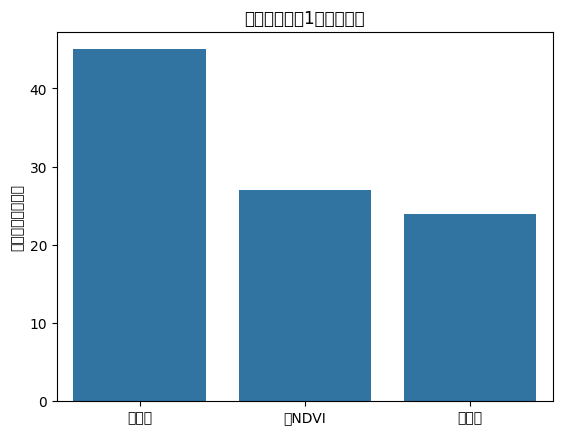

In [ ]:
# 简单条形图：看三个交互项中有多少个 1
counts = {
    "高农业": df_ready['drought_post_high_agri'].sum(),
    "高NDVI": df_ready['drought_post_high_ndvi'].sum(),
    "高密度": df_ready['drought_post_high_density'].sum()
}

sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("交互项中值为1的样本数量")
plt.ylabel("样本数（条目数）")
plt.show()

In [46]:
df_ready.to_csv("data/guizhou_model_ready.csv", index=False)

### 处理建模前的表格

In [48]:
# 重命名密度字段统一命名
df_ready = df_ready.rename(columns={'pop_density_2000_x': 'pop_density_2000'})

# 删除冗余列
drop_cols = ['ndvi_all', 'median', 'system:index', '.geo', 'pop_density_2000_y']
df_ready = df_ready.drop(columns=drop_cols)

# 补全缺失
df_ready['ndvi_crop'] = df_ready['ndvi_crop'].fillna(0)
df_ready['ndvi_baseline'] = df_ready['ndvi_baseline'].fillna(0)

# 导出干净建模表
df_ready.to_csv("data/guizhou_model_clean.csv", index=False)


In [50]:
df_cleaned = pd.read_csv ("data/guizhou_model_clean.csv")
# 1. 补齐 pop_density_2000
mean_density = df_cleaned['pop_density_2000'].mean()
df_cleaned['pop_density_2000'] = df_cleaned['pop_density_2000'].fillna(mean_density)

# 2. 重新划定 high_density（建议使用更新后的分布）
threshold = df_cleaned['pop_density_2000'].quantile(0.75)
df_cleaned['high_density'] = (df_cleaned['pop_density_2000'] >= threshold).astype(int)

# 3. 重构交互项
df_cleaned['drought_post_high_density'] = df_cleaned['drought_post'] * df_cleaned['high_density']

In [51]:
df_cleaned.to_csv("data/guizhou_model_clean2.csv", index=False)

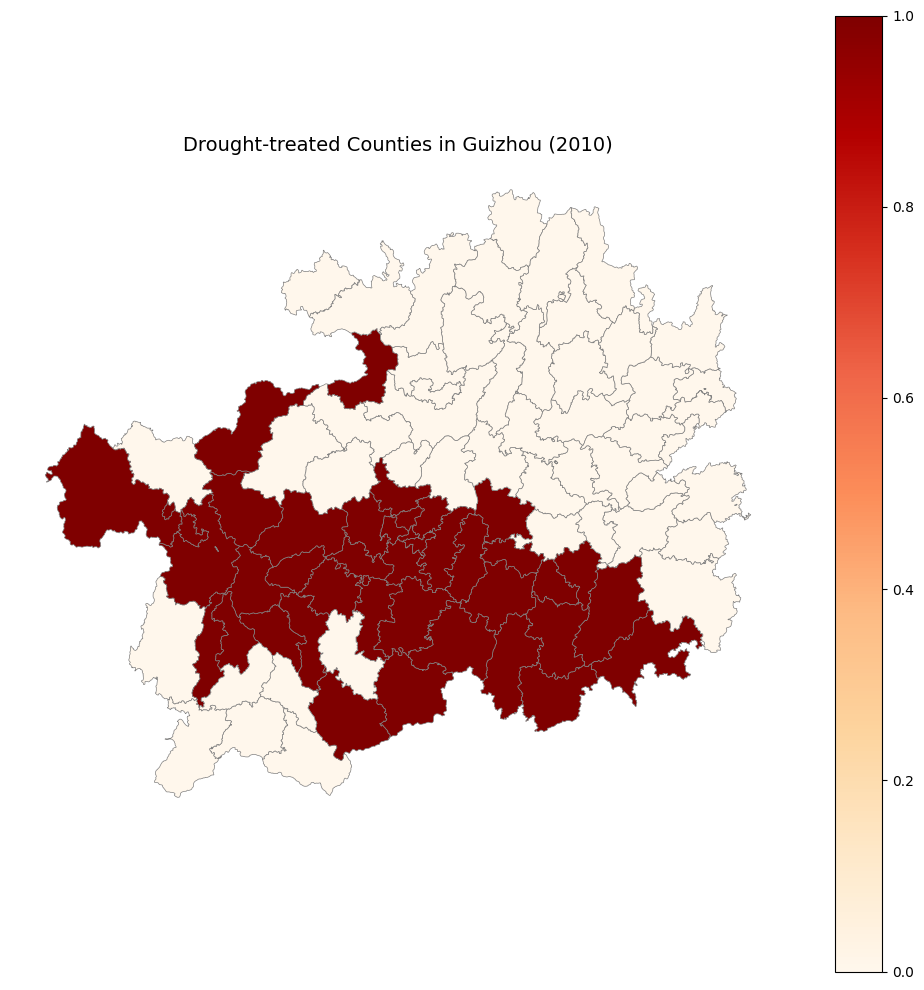

In [28]:
# === 1. 读取地理边界数据（贵州县级 shapefile）===
gdf = gpd.read_file("data/guizhou_county_shp/guizhou_county.shp")

# 确保有一列县名与你的 df 对应，例如 county_en 或 county_name
# 如需重命名，可使用：
# gdf = gdf.rename(columns={"NAME_EN": "ENG_NAME"})

# === 2. 读取模型数据 ===
df = pd.read_csv("data/guizhou_model_ready.csv")

# 取出 2010 年县名 + drought_treated 标签，去重
df_drought = df[df['year'] == 2010][['ENG_NAME', 'drought_treated']].drop_duplicates()

# === 3. 合并地图和数据 ===
gdf = gdf.merge(df_drought, on="ENG_NAME", how="left")

# 如果某些县未匹配到，则设为 0（默认非干旱县）
gdf['drought_treated'] = gdf['drought_treated'].fillna(0)

# === 4. 可视化 ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='drought_treated',
         cmap='OrRd', linewidth=0.5, edgecolor='gray',
         legend=True, ax=ax)

ax.set_title("Drought-treated Counties in Guizhou (2010)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

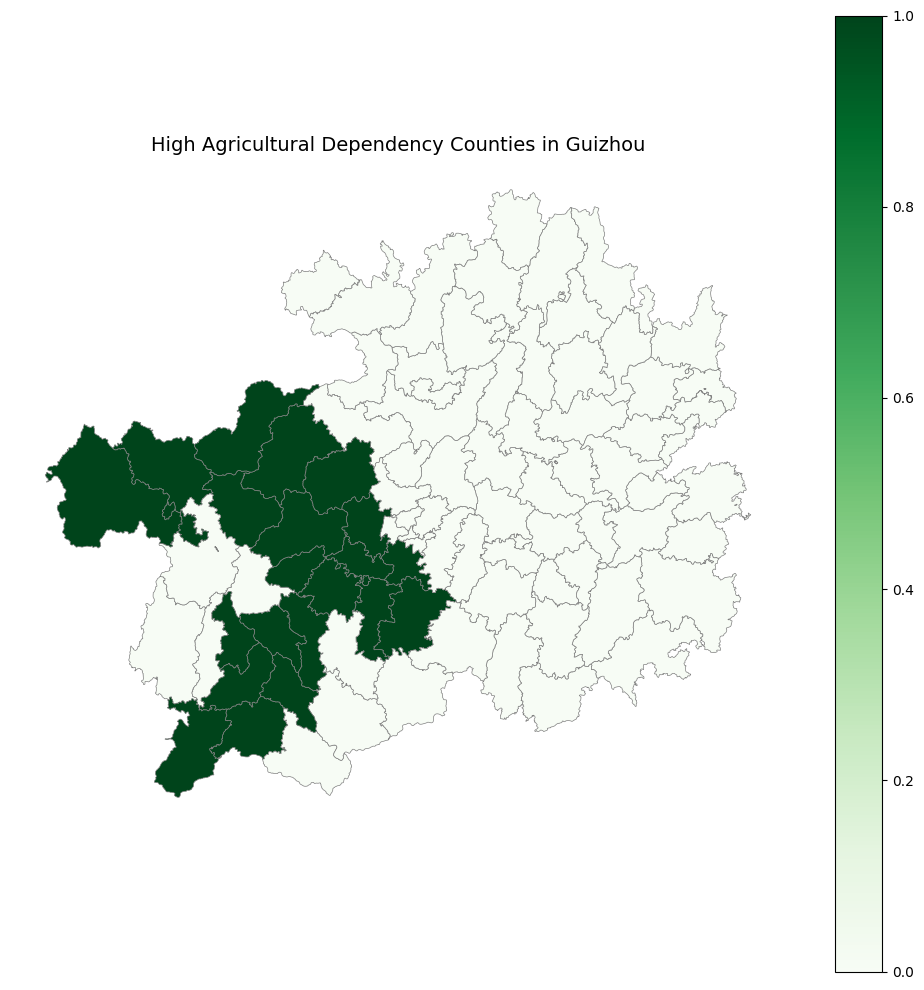

In [30]:
# 高农业依赖县
# === 1. 读取地图数据 ===
# === 2. 读取模型数据 ===

# 取唯一县 + 农业依赖标签（避免重复）
df_agri = df[['ENG_NAME', 'high_agriculture']].drop_duplicates()

# === 3. 合并地图和属性数据 ===
gdf = gdf.merge(df_agri, on="ENG_NAME", how="left")
gdf['high_agriculture'] = gdf['high_agriculture'].fillna(0)

# === 4. 画图 ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='high_agriculture',
         cmap='Greens', linewidth=0.5, edgecolor='gray',
         legend=True, ax=ax)

ax.set_title("High Agricultural Dependency Counties in Guizhou", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


## 4.2 DiD

### 4.2.0 女娲补天，搞忘合并人口数据

略

### 4.2.1 基础模型代码

In [1]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

In [5]:
# 加载数据
df = pd.read_csv("data/guizhou_model.csv")

# 删除主要结果变量缺失的观测
df_model = df.dropna(subset=['net_migration_per_1000', 'ndvi_crop'])

In [6]:
import statsmodels.formula.api as smf

# 模型 1：干旱对净迁移率的影响
model_mig = smf.ols(
    formula="net_migration_per_1000 ~ drought_post + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id']})

# 模型 2：干旱对农业活力（NDVI）的影响
model_ndvi = smf.ols(
    formula="ndvi_crop ~ drought_post + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id']})

# 打印结果
print(model_mig.summary())
print(model_ndvi.summary())


                              OLS Regression Results                              
Dep. Variable:     net_migration_per_1000   R-squared:                       0.459
Model:                                OLS   Adj. R-squared:                  0.313
Method:                     Least Squares   F-statistic:                     196.2
Date:                    Sun, 03 Aug 2025   Prob (F-statistic):           1.91e-41
Time:                            14:58:20   Log-Likelihood:                -1570.6
No. Observations:                     416   AIC:                             3319.
Df Residuals:                         327   BIC:                             3678.
Df Model:                              88                                         
Covariance Type:                  cluster                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 4
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [8]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# 假设 ndvi_model 和 migration_model 是你已经拟合好的模型结果对象
# 例如：
# ndvi_model = sm.OLS(...).fit(cov_type='cluster', cov_kwds={'groups': df['county_id']})
# migration_model = sm.OLS(...).fit(cov_type='cluster', cov_kwds={'groups': df['county_id']})

# 生成回归结果表
results_table = summary_col(
    results=[model_ndvi, model_mig],
    float_format='%0.4f',
    stars=True,
    model_names=['NDVI (cropland)', 'Net migration per 1000'],
    info_dict={
        'N':lambda x: f"{int(x.nobs)}",
        'R2':lambda x: f"{x.rsquared:.3f}"
    }
)

# 打印
print(results_table)

# # 如果你要导出到LaTeX：
# with open('regression_results.tex', 'w') as f:
#     f.write(results_table.as_latex())



                   NDVI (cropland) Net migration per 1000
---------------------------------------------------------
Intercept          0.5266***       3.0931*               
                   (0.0027)        (1.8677)              
C(county_id)[T.1]  0.0249***       3.9190                
                   (0.0027)        (2.3987)              
C(county_id)[T.2]  0.0349***       -19.4240***           
                   (0.0000)        (0.0000)              
C(county_id)[T.4]  0.0588***       -4.2720***            
                   (0.0000)        (0.0000)              
C(county_id)[T.5]  -0.4981***      -6.2400***            
                   (0.0000)        (0.0000)              
C(county_id)[T.6]  0.0210***       -4.1450*              
                   (0.0027)        (2.3987)              
C(county_id)[T.7]  -0.4981***      -4.8320***            
                   (0.0000)        (0.0000)              
C(county_id)[T.8]  0.0429***       -0.7370               
             

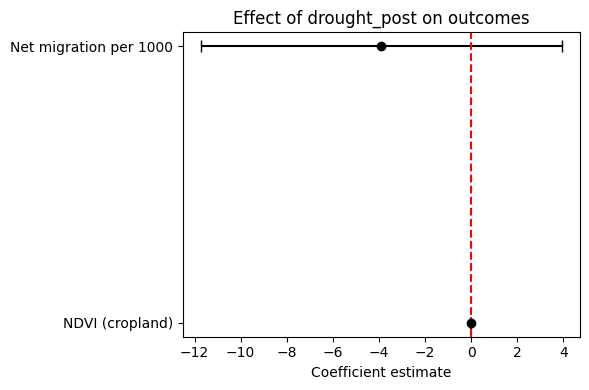

In [9]:
import matplotlib.pyplot as plt

# 从模型结果中提取 drought_post 系数和标准误
coef_data = [
    {
        'model': 'NDVI (cropland)',
        'coef': model_ndvi.params['drought_post'],
        'se': model_ndvi.bse['drought_post']
    },
    {
        'model': 'Net migration per 1000',
        'coef': model_mig.params['drought_post'],
        'se': model_mig.bse['drought_post']
    }
]

# 转为 DataFrame
import pandas as pd
df_coef = pd.DataFrame(coef_data)

# 绘制 coefplot
fig, ax = plt.subplots(figsize=(6,4))

ax.errorbar(
    df_coef['coef'],
    df_coef['model'],
    xerr=1.96 * df_coef['se'],  # 95% CI
    fmt='o',
    color='black',
    capsize=4
)

ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel('Coefficient estimate')
ax.set_ylabel('')
ax.set_title('Effect of drought_post on outcomes')

plt.tight_layout()
plt.show()

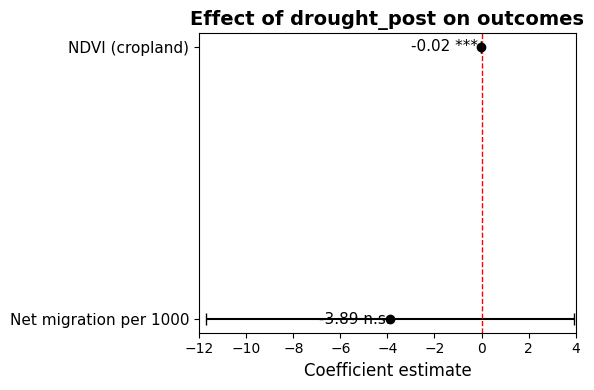

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据（替换成你模型的真实值）
coef_data = [
    {'model': 'NDVI (cropland)', 'coef': model_ndvi.params['drought_post'], 'se': model_ndvi.bse['drought_post'], 'pval': model_ndvi.pvalues['drought_post']},
    {'model': 'Net migration per 1000', 'coef': model_mig.params['drought_post'], 'se': model_mig.bse['drought_post'], 'pval': model_mig.pvalues['drought_post']}
]
df_coef = pd.DataFrame(coef_data)

# 反转顺序（农业在上，迁移在下）
df_coef = df_coef.iloc[::-1].reset_index(drop=True)

# 显著性符号函数
def significance_symbol(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return "n.s."

df_coef['sig'] = df_coef['pval'].apply(significance_symbol)

# 绘图
fig, ax = plt.subplots(figsize=(6,4))

ax.errorbar(
    df_coef['coef'],
    df_coef['model'],
    xerr=1.96 * df_coef['se'],
    fmt='o',
    color='black',
    capsize=4,
    markersize=6
)

# 零参考线
ax.axvline(0, color='red', linestyle='--', lw=1)

# 添加系数数值 + 显著性
for i, (coef, sig) in enumerate(zip(df_coef['coef'], df_coef['sig'])):
    # 根据正负号调整偏移
    if coef >= 0:
        ax.text(coef + 3, i, f"{coef:+.2f} {sig}", 
                va='center', fontsize=11, color='black')
    else:
        ax.text(coef - 3, i, f"{coef:+.2f} {sig}", 
                va='center', fontsize=11, color='black')

# 样式
ax.set_xlabel('Coefficient estimate', fontsize=12)
ax.set_ylabel('')
ax.set_title('Effect of drought_post on outcomes', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim(-12, 4)  # 根据实际数据调整范围

plt.tight_layout()
plt.show()


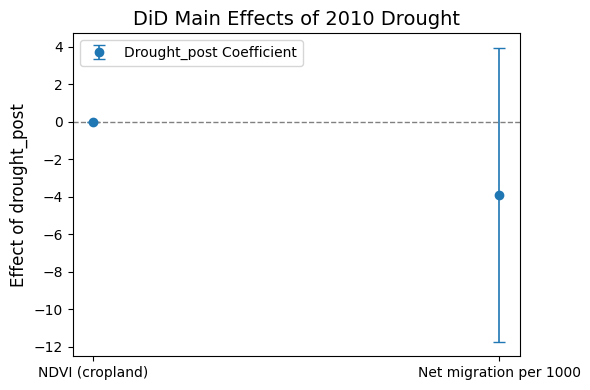

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据
coef_data = [
    {'model': 'NDVI (cropland)', 'coef': model_ndvi.params['drought_post'], 'se': model_ndvi.bse['drought_post']},
    {'model': 'Net migration per 1000', 'coef': model_mig.params['drought_post'], 'se': model_mig.bse['drought_post']}
]
df_coef = pd.DataFrame(coef_data)

# X 轴位置（分类变量）
x_pos = range(len(df_coef))

# 绘图
fig, ax = plt.subplots(figsize=(6,4))

# 绘制点和误差棒
ax.errorbar(
    x_pos,
    df_coef['coef'],
    yerr=1.96 * df_coef['se'],
    fmt='o',
    color='tab:blue',
    ecolor='tab:blue',
    elinewidth=1.2,
    capsize=4,
    label='Drought_post Coefficient'
)

# 零参考线
ax.axhline(0, color='gray', linestyle='--', lw=1)

# X 轴标签
ax.set_xticks(x_pos)
ax.set_xticklabels(df_coef['model'], rotation=0)

# 标签和标题
ax.set_ylabel('Effect of drought_post', fontsize=12)
ax.set_title('DiD Main Effects of 2010 Drought', fontsize=14)

# 图例
ax.legend()

plt.tight_layout()
plt.show()


### 4.2.2 Event Study

#### 1. 迁移数据

In [72]:
import statsmodels.formula.api as smf

# 回归：事件研究 + 固定效应 + 聚类稳健标准误
event_model = smf.ols(
    formula="net_migration_per_1000 ~ C(event_time) * drought_treated + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id'].values})

In [76]:
import re
import pandas as pd

# 修正后的提取逻辑：匹配交互项字符串
event_coefs = event_model.params[event_model.params.index.str.contains("event_time") & event_model.params.index.str.contains(":drought_treated")]
conf_int = event_model.conf_int().loc[event_coefs.index]

# 提取事件年份（τ）
import re
event_years = [int(re.search(r'C\(event_time\)\[T\.(-?\d+)\]', name).group(1)) for name in event_coefs.index]

# 构建绘图数据框
import pandas as pd
event_df = pd.DataFrame({
    'year': event_years,
    'coef': event_coefs.values,
    'ci_low': conf_int[0].values,
    'ci_high': conf_int[1].values
}).sort_values('year')


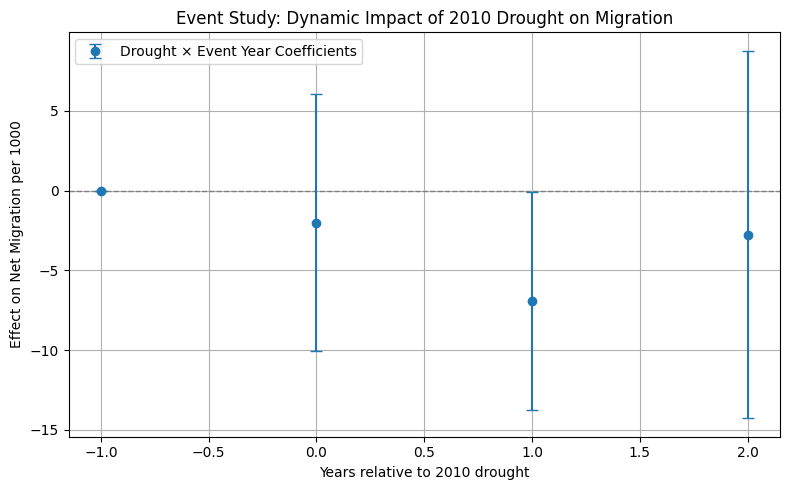

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.errorbar(event_df['year'], event_df['coef'],
             yerr=[event_df['coef'] - event_df['ci_low'], event_df['ci_high'] - event_df['coef']],
             fmt='o', capsize=4, label='Drought × Event Year Coefficients')

plt.xlabel("Years relative to 2010 drought")
plt.ylabel("Effect on Net Migration per 1000")
plt.title("Event Study: Dynamic Impact of 2010 Drought on Migration")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
print(event_model.params.index.tolist())


['Intercept', 'C(event_time)[T.-1]', 'C(event_time)[T.0]', 'C(event_time)[T.1]', 'C(event_time)[T.2]', 'C(county_id)[T.1]', 'C(county_id)[T.2]', 'C(county_id)[T.4]', 'C(county_id)[T.5]', 'C(county_id)[T.6]', 'C(county_id)[T.7]', 'C(county_id)[T.8]', 'C(county_id)[T.9]', 'C(county_id)[T.10]', 'C(county_id)[T.11]', 'C(county_id)[T.12]', 'C(county_id)[T.13]', 'C(county_id)[T.14]', 'C(county_id)[T.15]', 'C(county_id)[T.16]', 'C(county_id)[T.17]', 'C(county_id)[T.18]', 'C(county_id)[T.19]', 'C(county_id)[T.20]', 'C(county_id)[T.21]', 'C(county_id)[T.22]', 'C(county_id)[T.23]', 'C(county_id)[T.24]', 'C(county_id)[T.25]', 'C(county_id)[T.26]', 'C(county_id)[T.27]', 'C(county_id)[T.28]', 'C(county_id)[T.29]', 'C(county_id)[T.30]', 'C(county_id)[T.31]', 'C(county_id)[T.32]', 'C(county_id)[T.33]', 'C(county_id)[T.34]', 'C(county_id)[T.35]', 'C(county_id)[T.36]', 'C(county_id)[T.37]', 'C(county_id)[T.38]', 'C(county_id)[T.39]', 'C(county_id)[T.40]', 'C(county_id)[T.41]', 'C(county_id)[T.44]', 'C(

#### 2. NDVI

In [ ]:
# 回归模型：NDVI ~ 干旱组 × 事件年份 + 双固定效应 + 县级聚类稳健标准误
ndvi_event_model = smf.ols(
    formula="ndvi_crop ~ C(event_time) * drought_treated + C(county_id) + C(year)",
    data=df_model
).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id'].values})

In [79]:
# 提取干旱 × 事件年份交互项系数
ndvi_event_coefs = ndvi_event_model.params[
    ndvi_event_model.params.index.str.contains("event_time") & 
    ndvi_event_model.params.index.str.contains(":drought_treated")
]
ndvi_conf_int = ndvi_event_model.conf_int().loc[ndvi_event_coefs.index]

# 提取事件年份（τ）
ndvi_event_years = [int(re.search(r'C\(event_time\)\[T\.(-?\d+)\]', name).group(1)) for name in ndvi_event_coefs.index]

# 整理成绘图 DataFrame
ndvi_event_df = pd.DataFrame({
    'year': ndvi_event_years,
    'coef': ndvi_event_coefs.values,
    'ci_low': ndvi_conf_int[0].values,
    'ci_high': ndvi_conf_int[1].values
}).sort_values('year')

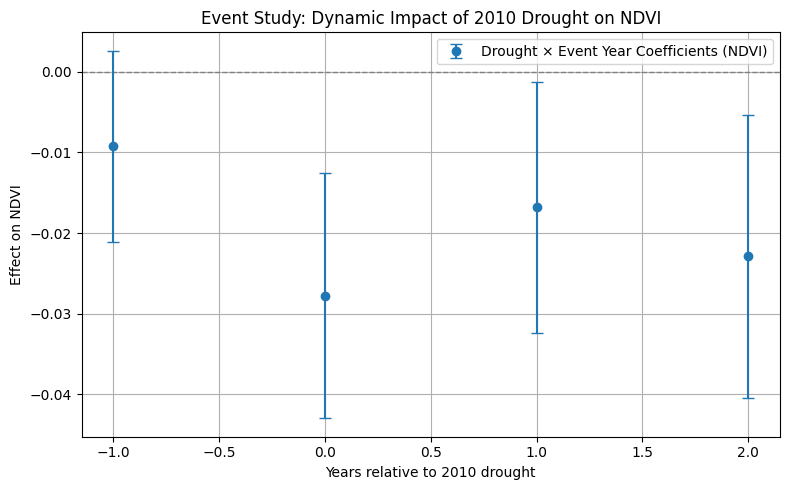

In [80]:
plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.errorbar(ndvi_event_df['year'], ndvi_event_df['coef'],
             yerr=[ndvi_event_df['coef'] - ndvi_event_df['ci_low'],
                   ndvi_event_df['ci_high'] - ndvi_event_df['coef']],
             fmt='o', capsize=4, label='Drought × Event Year Coefficients (NDVI)')

plt.xlabel("Years relative to 2010 drought")
plt.ylabel("Effect on NDVI")
plt.title("Event Study: Dynamic Impact of 2010 Drought on NDVI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 4.2.3 异质性分析

#### 1. high_density

In [82]:
for z in ['high_density', 'high_elev', 'urban_core']:
    df_model[f'drought_post_{z}'] = df_model['drought_post'] * df_model[z]
    formula = f"net_migration_per_1000 ~ drought_post + drought_post_{z} + C(county_id) + C(year)"
    model = smf.ols(formula=formula, data=df_model).fit(cov_type='cluster', cov_kwds={'groups': df_model['county_id'].values})
    print(f"\n--- Heterogeneity: {z} ---")
    print(model.summary().tables[1])



--- Heterogeneity: high_density ---
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.0931      1.871      1.654      0.098      -0.573       6.759
C(county_id)[T.1]             3.2919      2.503      1.315      0.188      -1.613       8.197
C(county_id)[T.2]           -19.4240   9.41e-14  -2.06e+14      0.000     -19.424     -19.424
C(county_id)[T.4]            -4.2720   8.67e-14  -4.93e+13      0.000      -4.272      -4.272
C(county_id)[T.5]            -6.2400   9.73e-14  -6.42e+13      0.000      -6.240      -6.240
C(county_id)[T.6]            -4.7721      2.503     -1.907      0.057      -9.677       0.133
C(county_id)[T.7]            -4.8320   9.09e-14  -5.31e+13      0.000      -4.832      -4.832
C(county_id)[T.8]            -1.3641      2.503     -0.545      0.586      -6.269       3.541
C(county_id)[T.9]      

C:\Users\10851\AppData\Local\Temp\ipykernel_20800\2863788471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f'drought_post_{z}'] = df_model['drought_post'] * df_model[z]
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 5
  warnings.warn('covariance of constraints does not have full '
C:\Users\10851\AppData\Local\Temp\ipykernel_20800\2863788471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

#### 4.2.3 改进中 

In [4]:
# 读取贵州 shp 文件路径
shp_path = "data/guizhou_county_shp/guizhou_county.shp"
gdf = gpd.read_file(shp_path)

# 提取中文和英文县名对应关系
county_map = gdf[['县级', 'ENG_NAME']].drop_duplicates()

# 导出为 CSV 文件
county_map.to_csv("guizhou_county_name_map.csv", index=False, encoding='utf-8-sig')

print("已成功导出县名对应表：guizhou_county_name_map.csv")

已成功导出县名对应表：guizhou_county_name_map.csv


In [7]:
import pandas as pd
import statsmodels.formula.api as smf

# 读取数据
df_model = pd.read_csv("data/guizhou_model_with_structure_vars_named.csv")

#####  1. dummy变量

In [18]:
# 复制一个新表防止覆盖原始数据
df_model = df_model.copy()

# 连续变量列表（从你提供的变量中筛选）
cont_vars = ['pop_density', 'agri_employ_ratio', 'agri_gdp_ratio',
             'gdp_pc', 'income_rural', 'elev_mean']

# 遍历生成 dummy 变量（大于中位数为1，否则为0）
for var in cont_vars:
    median_val = df_model[var].median()
    dummy_name = f"{var}_dummy"
    df_model[dummy_name] = (df_model[var] > median_val).astype(int)

# 检查生成结果
print(df_model[[f"{v}_dummy" for v in cont_vars]].head())

   pop_density_dummy  agri_employ_ratio_dummy  agri_gdp_ratio_dummy  \
0                  1                        0                     0   
1                  0                        0                     0   
2                  1                        1                     0   
3                  0                        0                     0   
4                  1                        1                     1   

   gdp_pc_dummy  income_rural_dummy  elev_mean_dummy  
0             0                   0                1  
1             0                   0                0  
2             0                   0                1  
3             1                   0                1  
4             0                   0                1  


In [21]:
import pandas as pd
import statsmodels.formula.api as smf

# ===== 1. 确保 county_id 是整数 =====
df_model = df_model.copy()
df_model['county_id'] = df_model['county_id'].astype(int)

# ===== 2. 定义结构变量列表 =====
hetero_vars = [
    'pop_density_dummy',
    'agri_employ_ratio_dummy',
    'agri_gdp_ratio_dummy',
    'gdp_pc_dummy',
    'income_rural_dummy',
    'elev_mean_dummy'
]

# ===== 3. 创建交互项 =====
for var in hetero_vars:
    interaction = f'drought_post_{var}'
    df_model[interaction] = df_model['drought_post'] * df_model[var]

# ===== 4. 剔除涉及变量的缺失行 =====
all_model_vars = (
    ['net_migration_per_1000', 'drought_post', 'county_id', 'year'] +
    hetero_vars + [f'drought_post_{v}' for v in hetero_vars]
)
df_model_clean = df_model.dropna(subset=all_model_vars)

# ===== 5. 逐变量回归分析 =====
for var in hetero_vars:
    interaction = f'drought_post_{var}'
    formula = f"net_migration_per_1000 ~ drought_post + {interaction} + C(county_id) + C(year)"
    
    model = smf.ols(formula=formula, data=df_model_clean).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_model_clean['county_id']}
    )
    
    print(f"\n--- Heterogeneity Test: {var} ---")
    print(model.summary().tables[1])



--- Heterogeneity Test: pop_density_dummy ---
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.0931      1.871      1.654      0.098      -0.573       6.759
C(county_id)[T.1]                  2.8328      2.677      1.058      0.290      -2.415       8.081
C(county_id)[T.2]                -19.4240   4.72e-14  -4.12e+14      0.000     -19.424     -19.424
C(county_id)[T.4]                 -4.2720      4e-14  -1.07e+14      0.000      -4.272      -4.272
C(county_id)[T.5]                 -6.2400   4.26e-14  -1.47e+14      0.000      -6.240      -6.240
C(county_id)[T.6]                 -5.2312      2.677     -1.954      0.051     -10.479       0.017
C(county_id)[T.7]                 -4.8320   5.53e-14  -8.73e+13      0.000      -4.832      -4.832
C(county_id)[T.8]                 -1.8232      2.677     -0.68

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 5
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 5
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 5
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of 

##### 2. 连续变量

In [8]:
# 设定连续变量列表
structure_vars = [
    'pop_density',        # 人口密度
    'agri_employ_ratio',  # 农林牧渔就业比
    'agri_gdp_ratio',     # 第一产业增加值占比
    'gdp_pc',             # 人均GDP
    'income_rural',       # 农民人均收入
    'elev_mean'           # 平均海拔
]

In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

In [10]:
# 拷贝数据，避免修改原始df
df_model_std = df_model.copy()

# 剔除缺失值（只对涉及的列）
columns_needed = structure_vars + ['drought_post', 'net_migration_per_1000', 'county_id', 'year']
df_model_std = df_model_std.dropna(subset=columns_needed)

# 标准化连续结构变量
scaler = StandardScaler()
for var in structure_vars:
    df_model_std[f'{var}_std'] = scaler.fit_transform(df_model_std[[var]])

# 创建交互项（结构变量 × drought_post）
for var in structure_vars:
    std_var = f'{var}_std'
    interaction_term = f'drought_post_{var}_std'
    df_model_std[interaction_term] = df_model_std['drought_post'] * df_model_std[std_var]

# 批量建模与输出
for var in structure_vars:
    interaction_term = f'drought_post_{var}_std'
    formula = f"net_migration_per_1000 ~ drought_post + {var}_std + {interaction_term} + C(county_id) + C(year)"
    model = smf.ols(formula, data=df_model_std).fit(cov_type='cluster', cov_kwds={'groups': df_model_std['county_id']})

    print(f"\n=== Heterogeneity Analysis: {var} ===")
    print(model.summary().tables[1])



=== Heterogeneity Analysis: pop_density ===
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.3254      7.053      0.330      0.742     -11.498      16.149
C(county_id)[T.2]              -17.4576     26.135     -0.668      0.504     -68.681      33.766
C(county_id)[T.4]               -8.2006     52.213     -0.157      0.875    -110.537      94.136
C(county_id)[T.5]               -7.9529     22.765     -0.349      0.727     -52.572      36.666
C(county_id)[T.6]               -6.7891     16.972     -0.400      0.689     -40.054      26.476
C(county_id)[T.7]               -6.2131     18.355     -0.338      0.735     -42.188      29.762
C(county_id)[T.8]               -6.4977     45.157     -0.144      0.886     -95.004      82.009
C(county_id)[T.9]               -1.2081     45.187     -0.027      0.979     -89.7

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 80, but rank is 7
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 80, but rank is 7
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 80, but rank is 7
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of 

                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5817      1.862      0.312      0.755      -3.069       4.232
C(county_id)[T.2]            -11.8121      0.909    -12.991      0.000     -13.594     -10.030
C(county_id)[T.4]             -0.2696      0.478     -0.564      0.573      -1.207       0.667
C(county_id)[T.5]             -0.4495      0.692     -0.650      0.516      -1.805       0.906
C(county_id)[T.6]             -3.8123      2.442     -1.561      0.119      -8.599       0.974
C(county_id)[T.7]             -0.0521      0.571     -0.091      0.927      -1.171       1.067
C(county_id)[T.8]              1.0451      2.295      0.455      0.649      -3.453       5.543
C(county_id)[T.9]             -7.0878      0.296    -23.928      0.000      -7.668      -6.507
C(county_id)[T.10]            -0.1113      2.223  

##### 3. 子样本回归

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# 读取数据
df_model = pd.read_csv("data/guizhou_model_struct_dummy_vars.csv")

In [12]:
dummy_vars = ['high_pop_density', 'high_agri_employ_ratio', 'high_agri_gdp_ratio',
 'high_gdp_pc', 'high_income_rural', 'high_elev_mean']

In [16]:
import pandas as pd
import statsmodels.formula.api as smf

# ==== 设置变量 ====
dummy_vars = [
    'high_pop_density',
    'high_agri_employ_ratio',
    'high_agri_gdp_ratio',
    'high_gdp_pc',
    'high_income_rural',
    'high_elev_mean'
]
core_vars = ['net_migration_per_1000', 'drought_post', 'county_id', 'year']

# ==== 存储结果 ====
results = []

# ==== 子样本回归循环 ====
for dummy in dummy_vars:
    df_sub = df_model[core_vars + [dummy]].dropna()

    for group_value, group_df in df_sub.groupby(dummy):
        label = f"{dummy} = {int(group_value)}"
        model = smf.ols("net_migration_per_1000 ~ drought_post + C(county_id) + C(year)", data=group_df).fit(
            cov_type='cluster', cov_kwds={'groups': group_df['county_id']}
        )
        results.append({
            'Group': label,
            'N': len(group_df),
            'Coef (drought_post)': model.params.get('drought_post', float('nan')),
            'StdErr': model.bse.get('drought_post', float('nan')),
            'P-value': model.pvalues.get('drought_post', float('nan'))
        })

# ==== 转为 DataFrame ====
results_df = pd.DataFrame(results)
print(results_df)

                         Group    N  Coef (drought_post)    StdErr   P-value
0         high_pop_density = 0  233            -3.829254  4.378806  0.381848
1         high_pop_density = 1  183            -4.570410  7.040172  0.516216
2   high_agri_employ_ratio = 0  233            -6.056822  6.631537  0.361066
3   high_agri_employ_ratio = 1  183            -3.411327  7.000682  0.626056
4      high_agri_gdp_ratio = 0  209            -2.622613  6.488110  0.686052
5      high_agri_gdp_ratio = 1  207             2.062171  5.295882  0.696987
6              high_gdp_pc = 0  212            -3.960012  4.733690  0.402840
7              high_gdp_pc = 1  204             4.108214  8.151799  0.614287
8        high_income_rural = 0  210            -4.765152  5.729594  0.405593
9        high_income_rural = 1  206            -0.974726  8.098769  0.904202
10          high_elev_mean = 0  206             3.755717  5.202969  0.470392
11          high_elev_mean = 1  210           -10.454286  8.221339  0.203514

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


                Group       Coef (SE)  P-value
 High pop density = 0  -3.829 (4.379) 0.381848
 High pop density = 1  -4.570 (7.040) 0.516216
 High agri employ = 0  -6.057 (6.632) 0.361066
 High agri employ = 1  -3.411 (7.001) 0.626056
    High agri GDP = 0  -2.623 (6.488) 0.686052
    High agri GDP = 1   2.062 (5.296) 0.696987
      High GDP pc = 0  -3.960 (4.734) 0.402840
      High GDP pc = 1   4.108 (8.152) 0.614287
High income rural = 0  -4.765 (5.730) 0.405593
High income rural = 1  -0.975 (8.099) 0.904202
   High elevation = 0   3.756 (5.203) 0.470392
   High elevation = 1 -10.454 (8.221) 0.203514


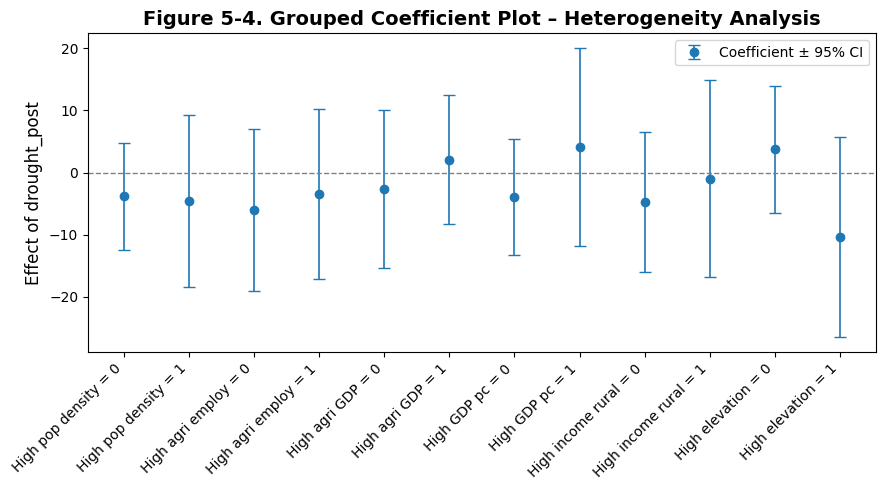

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 你的真实异质性分析结果
df_hetero = pd.DataFrame({
    'group': [
        'High pop density = 0', 'High pop density = 1',
        'High agri employ = 0', 'High agri employ = 1',
        'High agri GDP = 0', 'High agri GDP = 1',
        'High GDP pc = 0', 'High GDP pc = 1',
        'High income rural = 0', 'High income rural = 1',
        'High elevation = 0', 'High elevation = 1'
    ],
    'coef': [
        -3.829254, -4.570410,
        -6.056822, -3.411327,
        -2.622613,  2.062171,
        -3.960012,  4.108214,
        -4.765152, -0.974726,
         3.755717, -10.454286
    ],
    'se': [
        4.378806, 7.040172,
        6.631537, 7.000682,
        6.488110, 5.295882,
        4.733690, 8.151799,
        5.729594, 8.098769,
        5.202969, 8.221339
    ],
    'pval': [
        0.381848, 0.516216,
        0.361066, 0.626056,
        0.686052, 0.696987,
        0.402840, 0.614287,
        0.405593, 0.904202,
        0.470392, 0.203514
    ]
})

# 添加显著性标记
def sig_symbol(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return ""

df_hetero['sig'] = df_hetero['pval'].apply(sig_symbol)

# 格式化结果列
df_hetero['coef_se'] = df_hetero.apply(
    lambda x: f"{x['coef']:.3f} ({x['se']:.3f}){x['sig']}", axis=1
)

# === 生成回归结果表（论文用） ===
df_table = df_hetero[['group', 'coef_se', 'pval']].copy()
df_table.rename(columns={'group': 'Group', 'coef_se': 'Coef (SE)', 'pval': 'P-value'}, inplace=True)

# 打印表格
print(df_table.to_string(index=False))

# # 如果要导出 LaTeX（论文）
# with open("heterogeneity_results.tex", "w") as f:
#     f.write(df_table.to_latex(index=False, escape=False))

# === 绘制 Grouped Coefficient Plot ===
x_pos = np.arange(len(df_hetero))

fig, ax = plt.subplots(figsize=(9,5))

ax.errorbar(
    x_pos,
    df_hetero['coef'],
    yerr=1.96 * df_hetero['se'],
    fmt='o',
    color='tab:blue',
    ecolor='tab:blue',
    elinewidth=1.2,
    capsize=4,
    label='Coefficient ± 95% CI'
)

# 零参考线
ax.axhline(0, color='gray', linestyle='--', lw=1)

# X 轴标签
ax.set_xticks(x_pos)
ax.set_xticklabels(df_hetero['group'], rotation=45, ha='right')

# 轴标签和标题
ax.set_ylabel('Effect of drought_post', fontsize=12)
ax.set_title('Figure 5‑4. Grouped Coefficient Plot – Heterogeneity Analysis',
             fontsize=14, fontweight='bold')

# 图例
ax.legend()

plt.tight_layout()
plt.show()

## 4.2.4 鲁棒性分析

#### 1. 干旱定义

##### 1.1 按干旱像元大小

In [18]:
# 替代干旱变量：像元比例超过 0.4，且在 2010 年后（post 干旱处理）
df_model['drought_post_alt'] = (
    (df_model['drought_pixel_rate'] > 0.4) & (df_model['post_2010'] == 1)
).astype(int)

In [19]:
import statsmodels.formula.api as smf

# 剔除缺失值
df_alt = df_model.dropna(subset=['drought_post_alt', 'net_migration_per_1000', 'county_id', 'year'])

# 回归模型
model_alt = smf.ols(
    "net_migration_per_1000 ~ drought_post_alt + C(county_id) + C(year)",
    data=df_alt
).fit(cov_type='cluster', cov_kwds={'groups': df_alt['county_id']})

# 输出回归表格（可用于论文）
print(model_alt.summary().tables[1])

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5526      1.291      3.526      0.000       2.022       7.083
C(county_id)[T.1]      1.0827      0.618      1.752      0.080      -0.129       2.294
C(county_id)[T.2]    -19.4240   5.61e-14  -3.46e+14      0.000     -19.424     -19.424
C(county_id)[T.4]     -4.7733      0.618     -7.723      0.000      -5.985      -3.562
C(county_id)[T.5]     -6.2400   4.79e-14   -1.3e+14      0.000      -6.240      -6.240
C(county_id)[T.6]     -6.9813      0.618    -11.295      0.000      -8.193      -5.770
C(county_id)[T.7]     -4.8320   4.83e-14     -1e+14      0.000      -4.832      -4.832
C(county_id)[T.8]     -3.5733      0.618     -5.781      0.000      -4.785      -2.362
C(county_id)[T.9]     -5.1093      0.618     -8.267      0.000      -6.321      -3.898
C(county_id)[T.10]    -4.2133      0.618   

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 4
  warnings.warn('covariance of constraints does not have full '


##### 1.2. 按NDVI_crop

        Definition      Coef     CI_low   CI_high   P-value    N
0         Original -3.891686 -11.727509  3.944137  0.330335  416
1  PixelRate > 0.4  2.506261  -3.550770  8.563292  0.417364  416
2       NDVI < 0.2  2.574315  -3.114355  8.262984  0.375097  416


e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


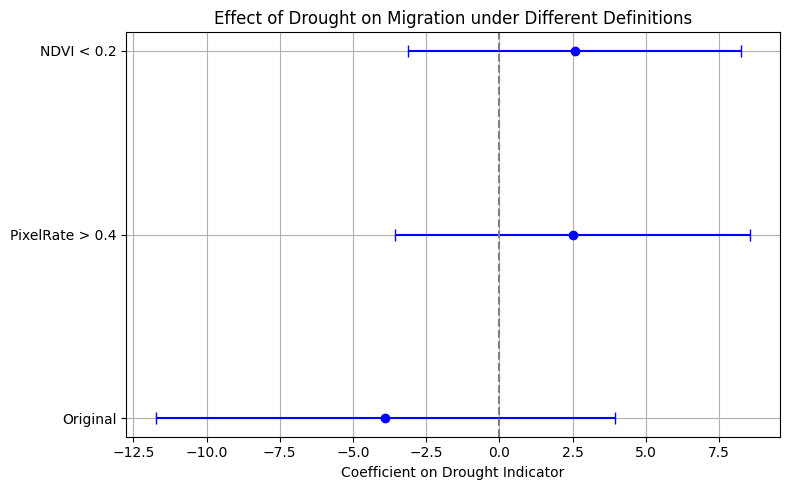

In [20]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Step 1: 构造两个替代干旱变量
df_model['drought_post_alt'] = ((df_model['drought_pixel_rate'] > 0.4) & (df_model['post_2010'] == 1)).astype(int)
df_model['drought_post_ndvi'] = ((df_model['ndvi_crop'] < 0.2) & (df_model['post_2010'] == 1)).astype(int)

# Step 2: 定义三种干旱变量
drought_defs = {
    'Original': 'drought_post',
    'PixelRate > 0.4': 'drought_post_alt',
    'NDVI < 0.2': 'drought_post_ndvi'
}

# Step 3: 回归并收集系数、置信区间等
coef_data = []

for label, drought_var in drought_defs.items():
    df_clean = df_model.dropna(subset=[drought_var, 'net_migration_per_1000', 'county_id', 'year'])
    model = smf.ols(
        formula=f"net_migration_per_1000 ~ {drought_var} + C(county_id) + C(year)",
        data=df_clean
    ).fit(cov_type='cluster', cov_kwds={'groups': df_clean['county_id']})
    
    coef = model.params[drought_var]
    se = model.bse[drought_var]
    ci_low = coef - 1.96 * se
    ci_high = coef + 1.96 * se
    pval = model.pvalues[drought_var]
    n = df_clean.shape[0]

    coef_data.append({
        'Definition': label,
        'Coef': coef,
        'CI_low': ci_low,
        'CI_high': ci_high,
        'P-value': pval,
        'N': n
    })

# Step 4: 整理为 DataFrame
coef_df = pd.DataFrame(coef_data)
print(coef_df)

# Step 5: 绘制 coefplot
plt.figure(figsize=(8, 5))
plt.errorbar(coef_df['Coef'], coef_df['Definition'],
             xerr=[coef_df['Coef'] - coef_df['CI_low'], coef_df['CI_high'] - coef_df['Coef']],
             fmt='o', capsize=4, color='blue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Coefficient on Drought Indicator")
plt.title("Effect of Drought on Migration under Different Definitions")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. 剔除极端值县

##### 2.1 鲁棒性结果

In [21]:
import numpy as np
import statsmodels.formula.api as smf

# Step 1: 剔除 net_migration_per_1000 极端值（±3σ）
migration_mean = df_model['net_migration_per_1000'].mean()
migration_std = df_model['net_migration_per_1000'].std()

df_trimmed = df_model[
    (df_model['net_migration_per_1000'] >= migration_mean - 3 * migration_std) &
    (df_model['net_migration_per_1000'] <= migration_mean + 3 * migration_std)
]

# Step 2: 拟合与主模型一致的回归
model_trimmed = smf.ols(
    "net_migration_per_1000 ~ drought_post + C(county_id) + C(year)",
    data=df_trimmed.dropna(subset=['drought_post', 'net_migration_per_1000', 'county_id', 'year'])
).fit(cov_type='cluster', cov_kwds={'groups': df_trimmed['county_id']})

# Step 3: 输出结果
print(model_trimmed.summary().tables[1])

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3055      1.442      2.293      0.022       0.480       6.131
C(county_id)[T.1]      3.5445      2.080      1.704      0.088      -0.533       7.622
C(county_id)[T.2]     -0.8768      0.281     -3.116      0.002      -1.428      -0.325
C(county_id)[T.4]     -4.2720   8.19e-14  -5.21e+13      0.000      -4.272      -4.272
C(county_id)[T.5]     -6.2400   8.22e-14  -7.59e+13      0.000      -6.240      -6.240
C(county_id)[T.6]     -4.5195      2.080     -2.172      0.030      -8.597      -0.442
C(county_id)[T.7]     -4.8320   8.28e-14  -5.84e+13      0.000      -4.832      -4.832
C(county_id)[T.8]     -1.1115      2.080     -0.534      0.593      -5.189       2.966
C(county_id)[T.9]    -18.5568      0.281    -65.953      0.000     -19.108     -18.005
C(county_id)[T.10]    -1.7515      2.080   

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 87, but rank is 4
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


##### 2.2 与主模型对比图 

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


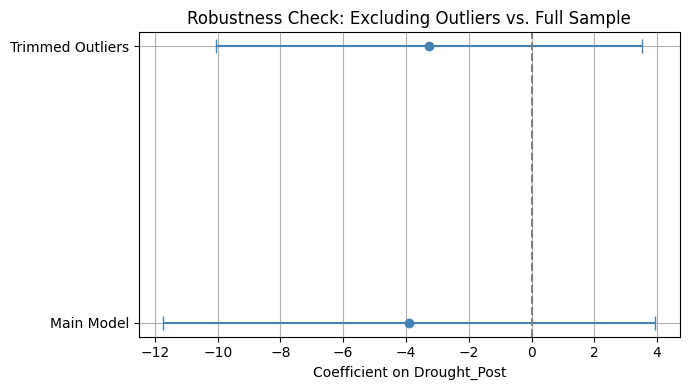

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Step 1: 数据清理（主模型）
df_clean_main = df_model.dropna(subset=['net_migration_per_1000', 'drought_post', 'county_id', 'year'])

# Step 2: 拟合主模型
model_main = smf.ols(
    formula="net_migration_per_1000 ~ drought_post + C(county_id) + C(year)",
    data=df_clean_main
).fit(cov_type='cluster', cov_kwds={'groups': df_clean_main['county_id']})

# Step 3: 构造极值剔除数据（±3σ）
migration_mean = df_model['net_migration_per_1000'].mean()
migration_std = df_model['net_migration_per_1000'].std()

df_trimmed = df_model[
    (df_model['net_migration_per_1000'] >= migration_mean - 3 * migration_std) &
    (df_model['net_migration_per_1000'] <= migration_mean + 3 * migration_std)
].dropna(subset=['net_migration_per_1000', 'drought_post', 'county_id', 'year'])

# Step 4: 拟合极值剔除后的模型
model_trim = smf.ols(
    formula="net_migration_per_1000 ~ drought_post + C(county_id) + C(year)",
    data=df_trimmed
).fit(cov_type='cluster', cov_kwds={'groups': df_trimmed['county_id']})

# Step 5: 汇总两个模型的 drought_post 系数与置信区间
def extract_coef(model, label):
    coef = model.params['drought_post']
    se = model.bse['drought_post']
    return {
        'Model': label,
        'Coef': coef,
        'CI_low': coef - 1.96 * se,
        'CI_high': coef + 1.96 * se
    }

coef_df = pd.DataFrame([
    extract_coef(model_main, 'Main Model'),
    extract_coef(model_trim, 'Trimmed Outliers')
])

# Step 6: 可视化 coefplot
plt.figure(figsize=(7, 4))
plt.errorbar(coef_df['Coef'], coef_df['Model'],
             xerr=[coef_df['Coef'] - coef_df['CI_low'], coef_df['CI_high'] - coef_df['Coef']],
             fmt='o', color='steelblue', capsize=5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Coefficient on Drought_Post")
plt.title("Robustness Check: Excluding Outliers vs. Full Sample")
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. 固定效应检验

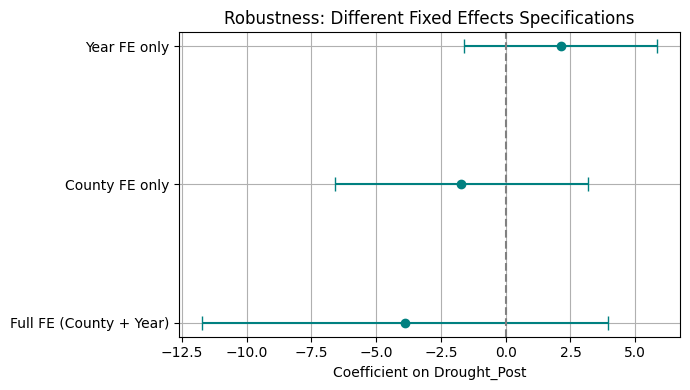

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Step 1: 清理公共字段缺失
fe_vars = ['net_migration_per_1000', 'drought_post', 'county_id', 'year']
df_clean = df_model.dropna(subset=fe_vars)

# Step 2: 定义三种固定效应设定
fe_models = {
    'Full FE (County + Year)': "net_migration_per_1000 ~ drought_post + C(county_id) + C(year)",
    'County FE only': "net_migration_per_1000 ~ drought_post + C(county_id)",
    'Year FE only': "net_migration_per_1000 ~ drought_post + C(year)",
}

results = []

# Step 3: 拟合并提取每个模型结果
for label, formula in fe_models.items():
    model = smf.ols(formula, data=df_clean).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_clean['county_id']}
    )
    coef = model.params.get('drought_post', None)
    se = model.bse.get('drought_post', None)
    if coef is not None and se is not None:
        results.append({
            'Model': label,
            'Coef': coef,
            'CI_low': coef - 1.96 * se,
            'CI_high': coef + 1.96 * se
        })

coef_df = pd.DataFrame(results)

# Step 4: 绘制 coefplot
plt.figure(figsize=(7, 4))
plt.errorbar(coef_df['Coef'], coef_df['Model'],
             xerr=[coef_df['Coef'] - coef_df['CI_low'], coef_df['CI_high'] - coef_df['Coef']],
             fmt='o', color='teal', capsize=5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Coefficient on Drought_Post")
plt.title("Robustness: Different Fixed Effects Specifications")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# 生成 DataFrame 展示表格
coef_table = coef_df.copy()
coef_table['Coef'] = coef_table['Coef'].round(3)
coef_table['CI_low'] = coef_table['CI_low'].round(3)
coef_table['CI_high'] = coef_table['CI_high'].round(3)
coef_table['95% CI'] = coef_table.apply(lambda row: f"[{row['CI_low']}, {row['CI_high']}]", axis=1)

# 仅展示关键列
display_table = coef_table[['Model', 'Coef', '95% CI']]

# 打印表格（或后续写入 CSV / LaTeX）
print(display_table.to_string(index=False))

                  Model   Coef           95% CI
Full FE (County + Year) -3.892 [-11.728, 3.944]
         County FE only -1.714  [-6.601, 3.174]
           Year FE only  2.126  [-1.595, 5.847]


### 4. 空间溢出控制

In [28]:
import pandas as pd
import geopandas as gpd
import libpysal
import statsmodels.formula.api as smf

# ===== 1. 加载 GeoDataFrame 并构建邻接矩阵 =====
# 注意：你需要提前加载 shapefile，并包含 county_id 或 ENG_NAME 字段
gdf = gpd.read_file('data/guizhou_county_shp/guizhou_county.shp')  # 替换为你的路径
gdf = gdf.sort_values('ENG_NAME').reset_index(drop=True)

# 构建 rook 邻接权重矩阵
w = libpysal.weights.Rook.from_dataframe(gdf, idVariable='ENG_NAME')
w.transform = 'R'

# 提取每个县的邻居列表
neighbors_dict = w.neighbors

# ===== 2. 生成邻县干旱比重变量 =====
# 获取 2010 年干旱情况
df_2010 = df_model[df_model['year'] == 2010][['ENG_NAME', 'drought_post']]

# 构造邻接干旱比例
neighbor_drought_share = []
for cid in df_2010['ENG_NAME']:
    neighbors = neighbors_dict.get(cid, [])
    if not neighbors:
        neighbor_drought_share.append(0)
    else:
        droughts = df_2010[df_2010['ENG_NAME'].isin(neighbors)]['drought_post'].sum()
        share = droughts / len(neighbors)
        neighbor_drought_share.append(share)

# 合并回 2010 数据
df_2010['drought_neighbors_share'] = neighbor_drought_share

# ===== 3. 合并邻接变量进主数据集 =====
df_model = df_model.merge(df_2010[['ENG_NAME', 'drought_neighbors_share']], on='ENG_NAME', how='left')

# ===== 4. 回归分析：控制邻县干旱比例 =====
df_clean_spillover = df_model.dropna(subset=[
    'net_migration_per_1000', 'drought_post', 'drought_neighbors_share',
    'ENG_NAME', 'year'
])

model_spillover = smf.ols(
    "net_migration_per_1000 ~ drought_post + drought_neighbors_share + C(ENG_NAME) + C(year)",
    data=df_clean_spillover
).fit(cov_type='cluster', cov_kwds={'groups': df_clean_spillover['ENG_NAME']})

print(model_spillover.summary().tables[1])

C:\Users\10851\AppData\Local\Temp\ipykernel_9444\2019393087.py:12: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = libpysal.weights.Rook.from_dataframe(gdf, idVariable='ENG_NAME')


                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   3.0931      1.871      1.654      0.098      -0.573       6.759
C(ENG_NAME)[T.Baiyun]                       1.6913      0.106     15.989      0.000       1.484       1.899
C(ENG_NAME)[T.Bijiang]                    -19.4240   7.07e-14  -2.75e+14      0.000     -19.424     -19.424
C(ENG_NAME)[T.Ceheng]                      -5.0146      0.766     -6.550      0.000      -6.515      -3.514
C(ENG_NAME)[T.Cengong]                     -6.2400    4.6e-14  -1.36e+14      0.000      -6.240      -6.240
C(ENG_NAME)[T.Changshun]                   -6.0014      0.489    -12.284      0.000      -6.959      -5.044
C(ENG_NAME)[T.Chishui]                     -4.8320   4.73e-14  -1.02e+14      0.000      -4.832      -4.832
C(ENG_NAME)[T.Congjiang]    

e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 4
  warnings.warn('covariance of constraints does not have full '
e:\study\CASA_dissertation\CASA_Dissertation\DiD\guizhou_env\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


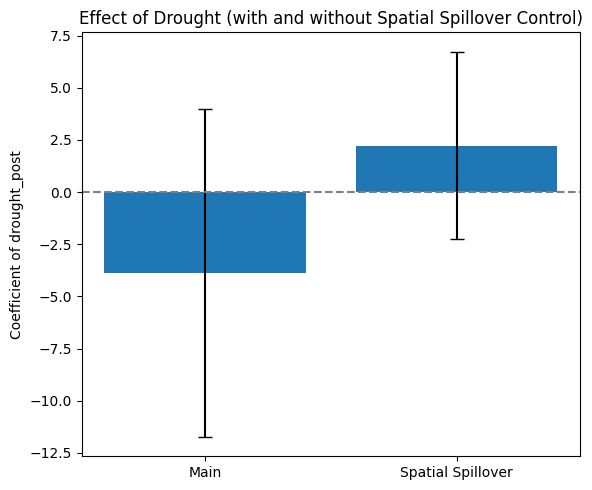

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# 模型结果（替换为你的真实估计结果）
results_df = pd.DataFrame({
    'Model': ['Main', 'Spatial Spillover'],
    'Coef': [-3.8917, 2.2277],  # 替换为你两个模型中的 drought_post 系数
    'StdErr': [4.004, 2.297]   # 替换为对应标准误
})

# 绘图
plt.figure(figsize=(6, 5))
plt.bar(results_df['Model'], results_df['Coef'], yerr=1.96 * results_df['StdErr'], capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Coefficient of drought_post')
plt.title('Effect of Drought (with and without Spatial Spillover Control)')
plt.tight_layout()
plt.show()